In [77]:
# Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

In [78]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [79]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS model_stage").collect()

[Row(status='MODEL_STAGE already exists, statement succeeded.')]

In [80]:
train_table = session.table(name="train_table")
test_table=session.table(name="test_table")

In [86]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_train_xgboost_model(session: Session, 
                              training_table: str, 
                              feature_cols: list,
                              target_col: str,
                              model_name: str) -> T.Variant:
    from joblib import dump
    import os
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    from xgboost import XGBClassifier
    xgbmodel = XGBClassifier(random_state=123)
    xgbmodel.fit(X,y)
    
    # Getting model coefficients
    feat_importance = pd.DataFrame(xgbmodel.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()

    # Save model as file and upload to Snowflake stage
    model_file = os.path.join('/tmp', model_name)
    dump(xgbmodel, model_file)
    session.file.put(model_file, '@MODEL_STAGE', auto_compress=False, overwrite=True)

    return feat_importance

In [87]:
# Registering the function as a Stored Procedure
sproc_xgboost_model = session.sproc.register(func=sproc_train_xgboost_model, 
                                            name='sproc_train_xgboost_model', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location='@MODEL_STAGE', 
                                            packages=[f'snowflake-snowpark-python==1.3.0'
                                                      ,f'scikit-learn==1.2.2'
                                                      ,f'xgboost==1.7.3'
                                                      ,f'joblib==1.1.1'])

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment


In [90]:
training_table = "frostbyte_tasty_bytes.analytics.train_table"
# get feature columns
feature_cols = train_table.drop('NEXTPURCHASEDAYRANGE').columns
target_col = 'NEXTPURCHASEDAYRANGE'
model_name = 'xgboost_model.sav'

feature_importance = sproc_xgboost_model(training_table, 
                                         feature_cols, 
                                         target_col,
                                         model_name, 
                                         session=session)

feature_importance = pd.DataFrame(eval(feature_importance))

In [91]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @MODEL_STAGE').collect())

,name,size,md5,last_modified
0,model_stage/xgb_churn_model.sav,36528,1a05a2eefcaccff7b8f7d6f9a016fb40,"Tue, 23 May 2023 15:04:42 GMT"
1,model_stage/xgboost_model.sav,320464,2534e1d9664c0248413e16244bee02e6,"Tue, 23 May 2023 15:59:37 GMT"


<Axes: >

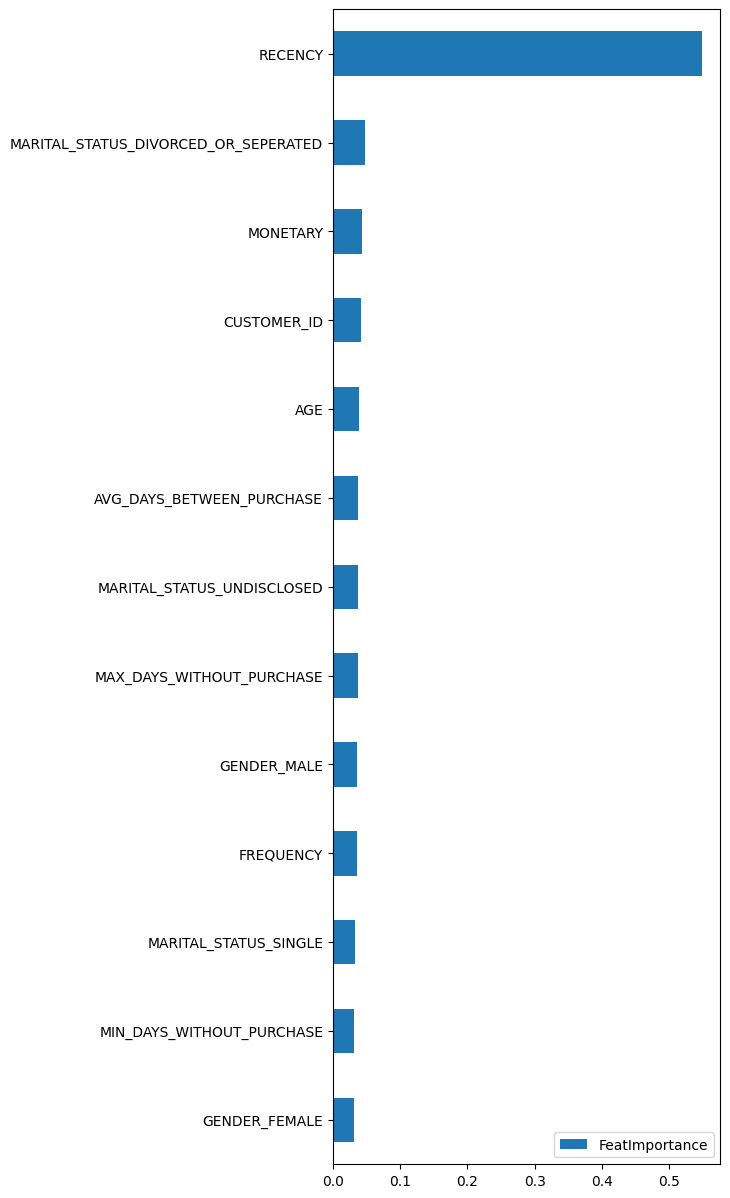

In [92]:
# Plot Feature Importance
feature_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

In [93]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'xgboost_model.sav'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [94]:
# Register UDF
udf_score_logistic_xgboost_model_vec_cached = session.udf.register(func=udf_score_logistic_xgboost_model_vec_cached, 
                                                                   name="udf_score_xgboost_model", 
                                                                   stage_location='@MODEL_STAGE',
                                                                   input_types=[T.FloatType()]*len(feature_cols),
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=['@MODEL_STAGE/xgboost_model.sav'],
                                                                   packages=[f'scikit-learn==1.2.2'
                                                                             ,f'xgboost==1.7.3'
                                                                             ,f'joblib==1.1.1'
                                                                             ,f'cachetools==4.2.2'], 
                                                                   session=session)

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package cachetools in the local environment is 5.3.0, which does not fit the criteria for the requirement cachetools==4.2.2. Your UDF might not work when the package version is different between the server and your local environment


In [95]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_table.with_column('PREDICTION', udf_score_logistic_xgboost_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='frostbyte_tasty_bytes.analytics.test_table', mode='overwrite')

CPU times: total: 0 ns
Wall time: 3.51 s
